In [1]:
import cv2
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
from time import time
from PIL import Image, ImageDraw, ImageFont

from core import ObjectDetector, CornerPredictor

In [2]:
dt_vehicle = ObjectDetector('yolov4-default')
dt_plate   = ObjectDetector('yolov4-plate_type')
dt_number  = ObjectDetector('yolov4-plate_number')
dt_corner  = CornerPredictor('corner_prediction')

<yolov4-default> model loaded.
<yolov4-plate_type> model loaded.
<yolov4-plate_number> model loaded.
<corner_prediction> model loaded.


In [3]:
def getPlateNumber(box, ptype, pnumber):
    number = ''
    order = box[:, 0, 0].argsort() # using x1 value to sort
    for o in order:
        number += pnumber[o]
    result = f'{number} ({ptype})'

    return result

def drawRectangle(img, box, color):
    if color == 'red':
        color = (255, 0, 0)
    elif color == 'green':
        color = (0, 255, 0)
    cv2.rectangle(img, (box[0, 0], box[0, 1]), (box[1, 0], box[1, 1]), color, 1)

    return img

def drawPlateNumber(img, result):
    img = cv2.resize(img, (200, 100))
    img = cv2.copyMakeBorder(img, 0, 25, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('font/msjh.ttc', 20, encoding='utf-8')
    draw.text((2, img.size[1]-28), result, font=font)
    img = np.array(img)

    return img

Number (Type):  ASQ5292 (白底黑字)
Recognition time: 0.143s


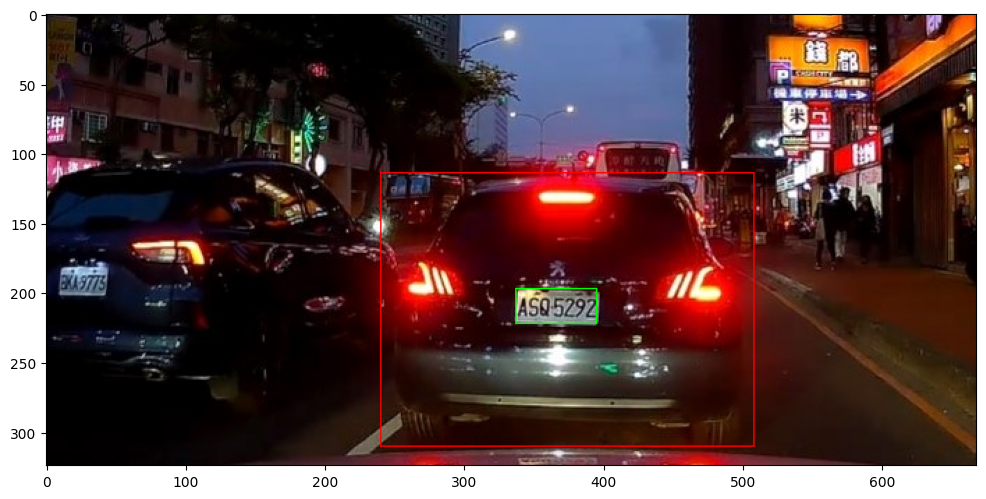

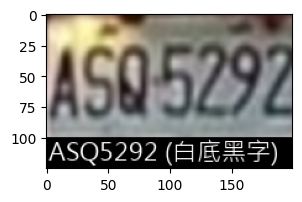

Number (Type):  BKA9773 (白底黑字)
Recognition time: 0.135s


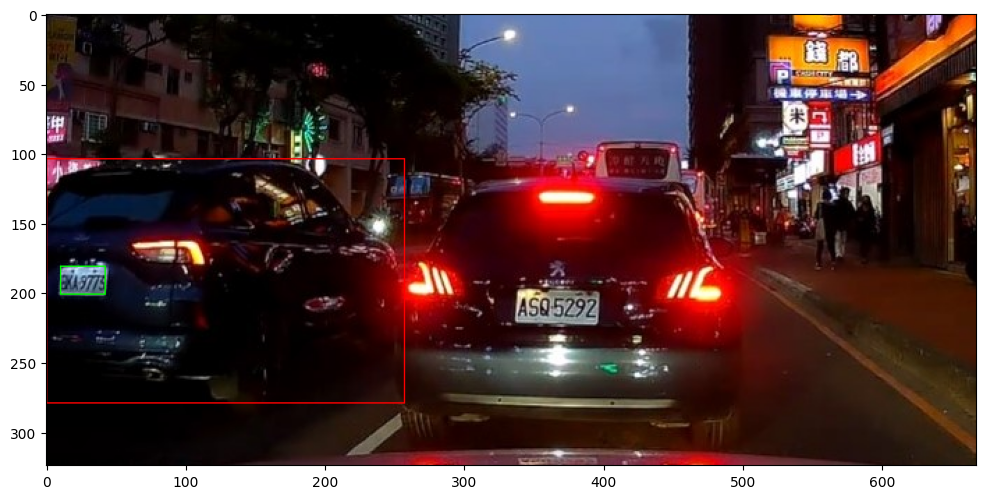

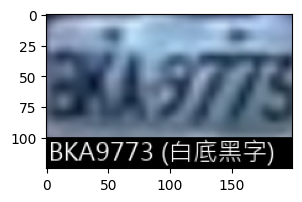

Total Recognition time: 0.278s


In [5]:
img_dir = 'images/test'
img_file = '511515.jpg'
img_path = osp.join(img_dir, img_file)

total_time = 0
MULTI_VEHICLES = True

start_time1 = time()
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
_ = dt_vehicle.loadImage(img)
bbox1, obj1 = dt_vehicle.runDetection(mode='vehicle', multi_res=MULTI_VEHICLES)
total_time1 = time() - start_time1

if len(bbox1) != 0:
    if not MULTI_VEHICLES:
        bbox1 = [bbox1]
    for box1 in bbox1:
        start_time2 = time()
        img_vehicle = dt_plate.loadImage(img, True, box1)
        bbox2, obj2 = dt_plate.runDetection(mode='plate')

        if len(bbox2) != 0:
            img_plate = dt_corner.loadImage(img_vehicle, True, bbox2)
            img_plate_warped, corner_pts = dt_corner.runPrediction()

            _ = dt_number.loadImage(img_plate_warped)
            bbox3, obj3 = dt_number.runDetection(mode='number', multi_res=True)

            if len(bbox3) != 0:
                result = getPlateNumber(bbox3, obj2, obj3)
                total_time2 = total_time1 + (time() - start_time2)
                total_time += total_time2
                print('Number (Type): ', result)
                print('Recognition time: {:.3f}s'.format(total_time2))

                img_copy = drawRectangle(img.copy(), box1, 'red')
                pts = np.array([[box1[0, 0]+bbox2[0, 0], box1[0, 1]+bbox2[0, 1]],
                                [box1[0, 0]+bbox2[1, 0], box1[0, 1]+bbox2[1, 1]]])
                img_copy = drawRectangle(img_copy, pts, 'green')              
                img_plate_warped = drawPlateNumber(img_plate_warped, result)
                
                plt.figure(figsize=(12, 7)); plt.imshow(img_copy)
                plt.figure(figsize=(5, 2)); plt.imshow(img_plate_warped)     
                plt.show()

print('Total Recognition time: {:.3f}s'.format(total_time))